# Count Arrays for Woolstenhulme E.coli data

This notebook contains a variety of code that allows me to create arrays of counts at each transcript position (nucleotide precision). 

Note that depending on the number of samples you are using, this notebook may use up a large amount of RAM (about 2-4 GB per sample). 

## loading packages

In [102]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, Transcript, ThreePrimeMapFactory
import numpy as np
import numpy
import pandas as pd
import warnings
import csv
from scipy.sparse.linalg import lsqr

In [103]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/ecol/'
p_site_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/p-site_offsets/ecol/'

## Defining Functions

In [104]:
def variable_threeprime_map_function(alignments,segment,p_offsets):
        '''
        This function is used to map read alignments to the location of the ribosomal p-site 
        from their 3' end. The offsets to use for each read length are specified by file
        generated using RiboWaltz.

        alignments:
            Information on the genome alignment of an individual read which is passed 
            to the function from a BamGenome array created by plastid. 

        segment:
            Information on the individual read segment which is passed 
            to the function from a BamGenome array created by plastid. 

        p_offsets:
            A pandas dataframe that has been loaded into the python environmemt.
            This dataframe should follow this template. 
                length          P_offsets
                 28              12
                 29              12
                 30              13
                ...             ...

        '''
        reads_out = []
        count_array = numpy.zeros(len(segment))
        for read in alignments: 
            for length, offset in zip(p_offsets["length"],p_offsets["p_offset"]): 
                if length != len(read.positions):
                    continue # skip read if it is not the length we are currently offsetting.

             # count offset 3' to 5' if the `segment` is on the plus-strand
             # or is unstranded
                if segment.strand == "+":
                    p_site = read.positions[-offset - 1]
                elif segment.strand == ".":
                    p_site = read.positions[-offset - 1]
             # count offset from other end if `segment` is on the minus-strand
                elif segment.strand == "-":
                    p_site = read.positions[offset]

                if p_site >= segment.start and p_site < segment.end:
                    reads_out.append(read)
                    count_array[p_site - segment.start] += 1
        return reads_out, count_array

In [105]:
def VariableThreePrimeMapFactory(p_offsets):
    '''
    BamGenome array objects will only be able to pass the alignments and segment
    arguments to the variable_threeprime_map_function. This wrapper allows me to
    also specify the offset that needs to be passed to the function. 
    '''
    def new_func(alignments,segment):
        return variable_threeprime_map_function(alignments,segment,p_offsets=p_offsets)

    return new_func

In [106]:
# Create a function that finds the proteins I need. 
def find_transcript(gene,transcripts, count_vectors):
    '''
    A function that takes the name of a gene as input and finds 
    the corresponding transcript from a transcript list. 
    
    returns both the transcript in question and the vector of counts for that transcript.
    
    This function is still a work in progress as for now it simply gives the last 
    transcript in the list that matches the gene ID. 
    '''
    for i in transcripts:
        if i.attr['transcript_biotype'] == 'protein_coding':
            if i.attr['gene_name'] == gene:
                my_transcript = i
                my_vector = count_vectors[transcripts.index(i)]
                index = transcripts.index(i)
                
    return my_transcript, my_vector, index

In [107]:
def find_max_list(list):
    ''' 
    A function that finds the longest list/array in a list of lists. 
    '''
    list_len = [len(i) for i in list]
    return(max(list_len))

## Loading up the data files 

In [108]:
# Load in the table of P-site offsets. 
#p_offsets=pd.read_csv(p_site_path + "control_RPF_2_p_offsets.txt", sep="\t")

Ok, Well this GTF file just straight up does not work. 

In [109]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + "Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.51.gtf"),return_type=Transcript))

In [110]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['transcript_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [111]:
transcripts[1].attr

{'transcript_id': 'AAC73113',
 'exon_number': '1',
 'transcript_source': 'ena',
 'gene_id': 'b0002',
 'score': '.',
 'transcript_biotype': 'protein_coding',
 'gene_biotype': 'protein_coding',
 'gene_name': 'thrA',
 'transcript_name': 'thrA-1',
 'source': 'ena',
 'gene_source': 'ena',
 'cds_genome_end': 2799,
 'cds_genome_start': 336,
 'type': 'mRNA'}

In [112]:
transcripts.clear()

In [114]:
# Read in the alignments from a BAM file and then have it map to the p-site 
alignments = BAMGenomeArray(data_path + "efp_RPF_1_Aligned.sortedByCoord.out.bam")
alignments.set_mapping(ThreePrimeMapFactory(13))

In [ ]:
# create a list to hold the vectors
count_vectors_control = []

# get counts for each transcript
for transcript in protein_coding:
    count_vectors_control.append(transcript.get_counts(alignments))

The function below takes a gene name as input and finds the correct transcript and vector for that gene. Note that this function is specifically made to work with the Drosophila_melanogaster.BDGP6.32.103.gtf file used to create the transcripts in this notebook. If you create the transcripts using a different file this function will need to be altered. 

## Analyzing the data files

In [98]:
#Get the transcript and vector for the gene of interest
my_transcript, my_vector, index = find_transcript('cysQ', protein_coding, count_vectors_control)

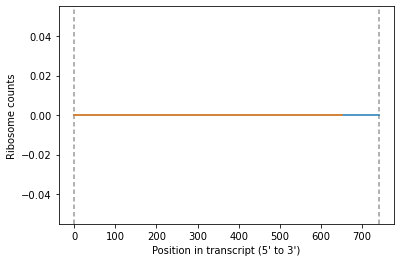

In [89]:
# 30-codon sliding window average
window = np.ones(90).astype(float)/90.0
sliding_window_avg = np.convolve(my_vector,window,mode="valid")


# plot
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(my_vector,label="%s counts" % my_transcript.get_name())
plt.plot(sliding_window_avg,label="30 codon average")
plt.xlabel("Position in transcript (5' to 3')")
plt.ylabel("Ribosome counts")

# add outlines at start & stop codons
plt.axvline(my_transcript.cds_start,color="#999999",dashes=[3,2],zorder=-1)
plt.axvline(my_transcript.cds_end,color="#999999",dashes=[3,2],zorder=-1)

transcript position 1230 to 1233 corresponds to the pause site for Xbp1. 

## Alter the count vectors to look at the codons over the cds region.

In [64]:
# Create a list that contains all of the gene_ids and transcript_ids of the transcripts
gene_id = []
transcript_id = []

for transcript in protein_coding:
    gene_id.append(transcript.attr["gene"])
    transcript_id.append(transcript.attr["ID"])

In [65]:
# Calculate the loacation of the start and end of the coding region for each transcript. 
cds_starts = []
cds_ends = []

for transcript in protein_coding:
    cds_starts.append(transcript.cds_start)
    cds_ends.append(transcript.cds_end)

In [66]:
# Create a list of lists containing the counts at each position of the transcript cds regions.
cds_counts_list = []

for i in range(len(count_vectors_control)):
    x = list(count_vectors_control[i][cds_starts[i]:cds_ends[i]])
    cds_counts_list.append(x)

In [67]:
# Convert the count lists from nucleotide resolution to codon resolution
codon_counts = []

for i in cds_counts_list:
    codon_counts.append(np.add.reduceat(i, np.arange(0, len(i),3)))

## Calculating Elongation rates

In [147]:
save_path = "/Users/keeganflanagan/Desktop/Khanh_position/Eggtart/"

In [148]:
# Choosing a gene of interest to calculate the elongation rates of. 
#Get the transcript and vector for the gene of interest
my_transcript, my_vector = find_transcript("RpS6", 
                                           protein_coding, codon_counts)

27049
27050


In [149]:
# calculate the normalized profile (p) of my vector of interest

M = sum(my_vector)
p = my_vector/M

In [150]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
x=0
pbar=[]
for px in p:
    pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
    pbar.append(pbar_x)
    x = x+1
    if x  == len(p)-9:
        break
pbar = np.array(pbar)

In [151]:
# calculate the smoothed, scaled elongation rate lambda bar 
lbar = []
for pbarx in pbar:
    if pbarx == 0:
        lbar_x=9999
    else:
        lbar_x = (1-9*pbarx)/(pbarx*(1-pbarx))

    lbar.append(lbar_x)
lbar = np.array(lbar)

In [152]:
# Calculate the scaled elongation and initiation rates
if pbar[0] == 0:
    sc_init = 1/(1-10*0.00001)
else:
    sc_init = 1/(1-10*pbar[0])
if p[-1] ==0:
    sc_term = 1/0.00001
else:
    sc_term = 1/(p[-1])

In [153]:
# L = 1 in this case so b is simply lbar list times 10. 
b = 10*lbar
A = np.zeros((len(lbar),len(p)))# I cannot seem to understand what A looks like yet.
x=0
for row in A:
    row[x:x+10].fill(1)
    x = x+1

ls_result=lsqr(A,b)

In [154]:
Ci = ls_result[0]

In [155]:
tau = Ci.mean()
prod_r = 1/tau

In [156]:
# Computing the unscaled rates
elongation = lbar/tau
termination = sc_term # This makes no sense, it always ends up being huge... maybe it is just len(p)/M?
initiation = sc_init/tau

In [159]:
initiation

0.0020798188186674314

My termination rates keep looking ridiculously small... I think I made a mistake while defining the codon regions.

Next time I run this I should just load up the old data file rather than recreating it. 

In [158]:
with open(save_path + 'RpS6_gene_test.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(np.atleast_2d(elongation).T)

## Save as a csv

In [69]:
# Create a list that contains all of the gene_ids and transcript_ids of the transcripts
gene_id = []
transcript_id = []

for transcript in protein_coding:
    gene_id.append(transcript.attr["gene"])
    transcript_id.append(transcript.attr["ID"])

In [73]:
# Insert the gene ids and transcript ids into the codon_count list. 
for i,j in zip(cds_counts_list, range(len(gene_id))):
    i.insert(0,gene_id[j])
    i.insert(0,transcript_id[j])

In [74]:
# Calculate the longest cds region in our new list of counts
l_tr = find_max_list(cds_counts_list)

# Define a header that includes labels for the transcript and gene ID as 
# well as numbers that index the cds region position.
header=["transcript_id","gene_id"]+list(range(l_tr))

# insert that header into our counts list. 
cds_counts_list.insert(0,header)

In [76]:
with open(save_path + 'efp_1_counts.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(cds_counts_list)

Do you think there is such thing as an average count array? I am just trying to figure out how we work multiple samples into this kind of analyses smoothly. 

Doing just the coding region should be as easy as indexing each transcript from my_count_vectors with the numbers you get from transcript.cds_start and transcript.cds_end

Hmmm, Perhaps I should keep the transcript position for the index rather than use the coding region position for the index? I mean it would be easy enough to fix but it is still kind of annoying. 